In [7]:
!export CUDA_VISIBLE_DEVICES=0

In [16]:
os.environ

KeysView(environ({'LC_PAPER': 'ru_RU.UTF-8', 'XDG_SESSION_ID': '1', 'LC_ADDRESS': 'ru_RU.UTF-8', 'SPARK_HOME': '/dsvm/tools/spark/current', 'LC_MONETARY': 'ru_RU.UTF-8', 'TERM': 'xterm-color', 'SHELL': '/bin/bash', 'SSH_CLIENT': '91.78.48.22 34250 22', 'CONDA_SHLVL': '2', 'LIBRARY_PATH': '/opt/intel/compilers_and_libraries_2018.1.163/linux/tbb/lib/intel64_lin/gcc4.7:/opt/intel/compilers_and_libraries_2018.1.163/linux/compiler/lib/intel64_lin:/opt/intel/compilers_and_libraries_2018.1.163/linux/mkl/lib/intel64_lin:/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64/:/opt/intel/compilers_and_libraries_2018.1.163/linux/tbb/lib/intel64_lin/gcc4.7:/opt/intel/compilers_and_libraries_2018.1.163/linux/compiler/lib/intel64_lin:/opt/intel/compilers_and_libraries_2018.1.163/linux/mkl/lib/intel64_lin:/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64/:/opt/intel/compilers_and_libraries_2018.1.163/linux/tbb/lib/intel64_lin/gcc4.7:/opt/intel/compilers_and_libraries_2018.1.163/linux/compile

In [8]:
import numpy as np
import pandas as pd 
from scipy.io import wavfile
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
np.random.seed(101)
import IPython.display as ipd
import os
from scipy import signal
print(os.listdir("./data"))
from tqdm import tqdm, tqdm_notebook; tqdm.pandas() # Progress bar
from sklearn.metrics import label_ranking_average_precision_score
from sklearn.model_selection import train_test_split

# Machine Learning
import tensorflow as tf
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.layers import (Dense, Bidirectional, CuDNNLSTM,
                          Dropout, LeakyReLU, Convolution2D, 
                          Conv2D, Conv1D)
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

import warnings; warnings.filterwarnings("ignore")
#print(os.listdir("../input/train_curated"))

['train_curated', 'test.zip', 'train_noisy.zip', 'train_curated.zip', 'test', 'train_curated.csv', 'train_noisy.csv', 'train_noisy', 'sample_submission.csv']


In [9]:
train_cur = pd.read_csv("./data/train_curated.csv")
train_nos = pd.read_csv("./data/train_noisy.csv")
test = pd.read_csv("./data/sample_submission.csv")

In [10]:
train_cur.head()

,fname,labels
0,0006ae4e.wav,Bark
1,0019ef41.wav,Raindrop
2,001ec0ad.wav,Finger_snapping
3,0026c7cb.wav,Run
4,0026f116.wav,Finger_snapping


In [11]:
train_nos.head()

,fname,labels
0,00097e21.wav,Bathtub_(filling_or_washing)
1,000b6cfb.wav,Motorcycle
2,00116cd2.wav,"Marimba_and_xylophone,Glockenspiel"
3,00127d14.wav,"Water_tap_and_faucet,Sink_(filling_or_washing)"
4,0019adae.wav,Raindrop


In [12]:
test.head()

,fname,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),Bicycle_bell,...,Toilet_flush,Traffic_noise_and_roadway_noise,Trickle_and_dribble,Walk_and_footsteps,Water_tap_and_faucet,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing)
0,000ccb97.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0012633b.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,001ed5f1.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,00294be0.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,003fde7a.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
train_audio_cur = "./data/train_curated/"
ipd.Audio(train_audio_cur+"31a0f9cc.wav")


In [10]:
train_cur.loc[train_cur['fname']=='31a0f9cc.wav']

,fname,labels
945,31a0f9cc.wav,Clapping


In [11]:
sampling_rate, data = wavfile.read(train_audio_cur+"31a0f9cc.wav")
print("Sampling Rate: {}".format(sampling_rate))
print("Data of the audio wave: {}".format(data))
print("Duration of Audio file: {}".format(len(data)/sampling_rate))

Sampling Rate: 44100
Data of the audio wave: [-3 -5 -4 ... -4 -8 -8]
Duration of Audio file: 0.3134920634920635


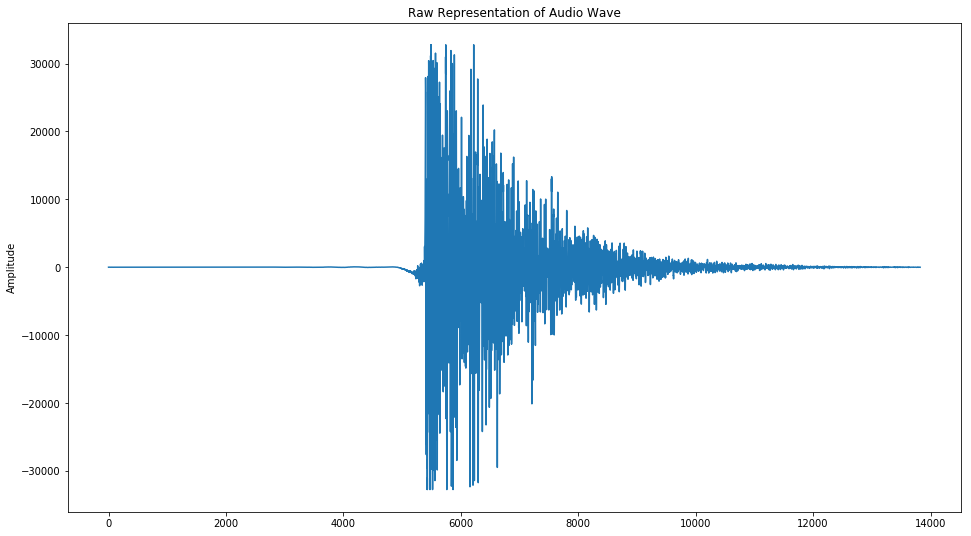

In [12]:
def plot_raw_wave(data):
    plt.figure(figsize=(16,9))
    plt.title("Raw Representation of Audio Wave")
    plt.ylabel("Amplitude")
    plt.plot(data)
plot_raw_wave(data)

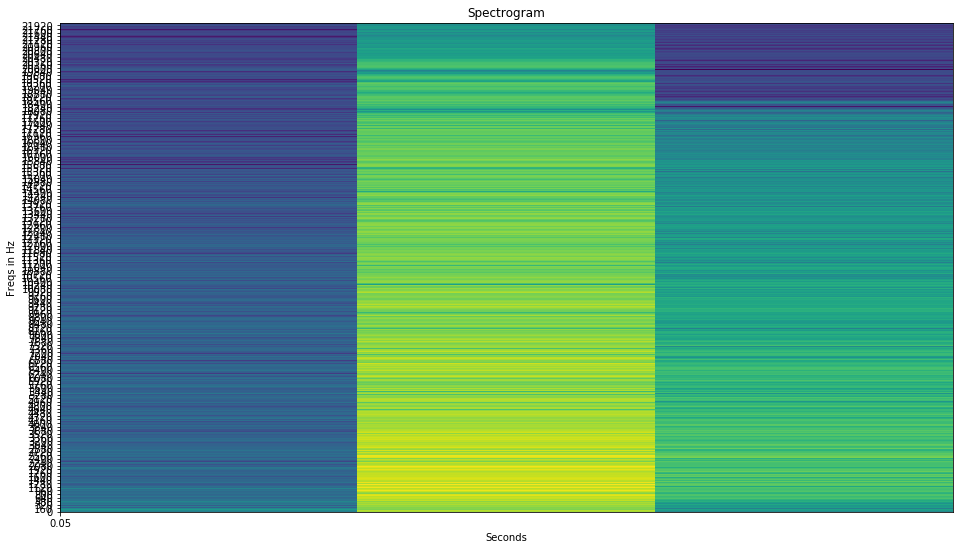

In [13]:
#https://www.kaggle.com/davids1992/audio-representation-what-it-s-all-about
def log_specgram(audio, sample_rate, window_size=100,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

def plot_log_specgram(audio, sample_rate, window_size=20, step_size=10, eps=1e-10):
    
    fig = plt.figure(figsize=(16,9))
    freqs, times, spectrogram = log_specgram(audio, sample_rate)
    plt.imshow(spectrogram.T, aspect='auto', origin='lower', 
               extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    plt.yticks(freqs[::16])
    plt.xticks(times[::16])
    plt.title('Spectrogram')
    plt.ylabel('Freqs in Hz')
    plt.xlabel('Seconds')
    plt.show()
plot_log_specgram(data, sampling_rate, window_size=1000,step_size=10)

In [14]:
import librosa
import librosa.display

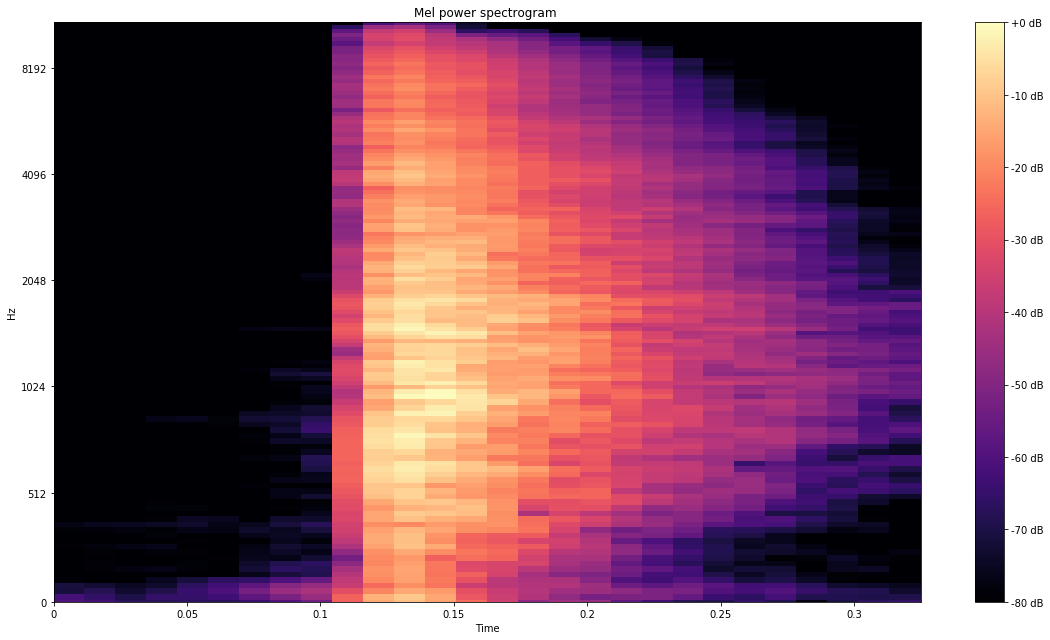

In [15]:
#https://www.kaggle.com/davids1992/audio-representation-what-it-s-all-about
S = librosa.feature.melspectrogram(data.astype(float), sr=sampling_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(16, 9))
librosa.display.specshow(log_S, sr=sampling_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

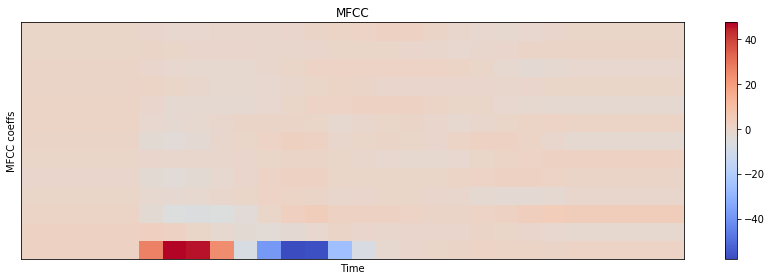

In [16]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In [17]:
def calculate_overall_lwlrap_sklearn(truth, scores):
    """Calculate the overall lwlrap using sklearn.metrics.lrap."""
    # sklearn doesn't correctly apply weighting to samples with no labels, so just skip them.
    sample_weight = np.sum(truth > 0, axis=1)
    nonzero_weight_sample_indices = np.flatnonzero(sample_weight > 0)
    overall_lwlrap = label_ranking_average_precision_score(
        truth[nonzero_weight_sample_indices, :] > 0, 
        scores[nonzero_weight_sample_indices, :], 
        sample_weight=sample_weight[nonzero_weight_sample_indices])
    return overall_lwlrap


In [18]:
def split_and_label(rows_label):
    labeled_rows = []
    for row in rows_label:
        rows_label = row.split(",")
        arr = np.zeros((80))
        for label in rows_label:
            idx = label_mapping[label]
            arr[idx] = 1
        labeled_rows.append(arr)
    return labeled_rows 

In [19]:
label_columns = test.columns[1:]
label_mapping = dict((label,index) for index, label in enumerate(label_columns))
print("Total Number of Classes: {}".format(len(label_columns)))

Total Number of Classes: 80


In [20]:
train_cur_labels = split_and_label(train_cur['labels'])
train_nos_labels = split_and_label(train_nos['labels'])

In [21]:
for col in label_columns:
    train_cur[col] = 0
    train_nos[col] = 0
train_cur[label_columns] = train_cur_labels
train_nos[label_columns] = train_nos_labels

In [22]:
train_cur.head()

,fname,labels,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),...,Toilet_flush,Traffic_noise_and_roadway_noise,Trickle_and_dribble,Walk_and_footsteps,Water_tap_and_faucet,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing)
0,0006ae4e.wav,Bark,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0019ef41.wav,Raindrop,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,001ec0ad.wav,Finger_snapping,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0026c7cb.wav,Run,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0026f116.wav,Finger_snapping,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
train_nos.head()

,fname,labels,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),...,Toilet_flush,Traffic_noise_and_roadway_noise,Trickle_and_dribble,Walk_and_footsteps,Water_tap_and_faucet,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing)
0,00097e21.wav,Bathtub_(filling_or_washing),0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,000b6cfb.wav,Motorcycle,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00116cd2.wav,"Marimba_and_xylophone,Glockenspiel",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00127d14.wav,"Water_tap_and_faucet,Sink_(filling_or_washing)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0019adae.wav,Raindrop,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
input_shape = (890,128)
n_classes = 80
n_epochs = 500
hop_length = 347
fmin = 20
fmax = sampling_rate // 2
n_mels = 128
n_fft = n_mels*20
opt = Adam(0.003, beta_1=0.75, beta_2=0.85, amsgrad=True)
sampling_rate = 44100
duration = 7
samples = sampling_rate*duration


Instructions for updating:
Colocations handled automatically by placer.


In [25]:
def read_audio(pathname, trim_long_data):
    y, sr = librosa.load(pathname, sr=sampling_rate)
    # trim silence
    if 0 < len(y): # workaround: 0 length causes error
        y, _ = librosa.effects.trim(y) # trim, top_db=default(60)
    # make it unified length to conf.samples
    if len(y) > samples: # long enough
        if trim_long_data:
            y = y[0:0+samples]
    else: # pad blank
        padding = samples - len(y)    # add padding at both ends
        offset = padding // 2
        y = np.pad(y, (offset, samples - len(y) - offset), 'constant')
    return y

def audio_to_melspectrogram(audio):
    spectrogram = librosa.feature.melspectrogram(audio, 
                                                 sr=sampling_rate,
                                                 n_mels=n_mels,
                                                 hop_length=hop_length,
                                                 n_fft=n_fft,
                                                 fmin=fmin,
                                                 fmax=fmax)
    spectrogram = librosa.power_to_db(spectrogram)
    spectrogram = spectrogram.astype(np.float32)
    return spectrogram

def read_as_melspectrogram(pathname, trim_long_data, debug_display=False):
    x = read_audio(pathname, trim_long_data)
    mels = audio_to_melspectrogram(x)
    if debug_display:
        IPython.display.display(IPython.display.Audio(x, rate=sampling_rate))
        show_melspectrogram(mels)
    return mels

def convert_wav_to_image(df, source):
    X = []
    for i, row in tqdm_notebook(df.iterrows()):
        try:
            x = read_as_melspectrogram(f'{source[0]}/{str(row.fname)}', trim_long_data=True)
        except:
            x = read_as_melspectrogram(f'{source[1]}/{str(row.fname)}', trim_long_data=True)

        #x_color = mono_to_color(x)
        X.append(x.transpose())
        #df.loc[i, 'length'] = x.shape[1]
    return X

In [28]:
train = pd.concat([train_cur[:4000],train_nos[:2000]])
train_curated_path = './data/train_curated/'
train_noisy_path = './data/train_noisy/'
test_path = './data/test/'
train.shape

(6000, 82)

In [29]:
%%time
#X = np.array(convert_wav_to_image(train_cur,source=[train_curated_path]))
#X = np.array(convert_wav_to_image(train_nos, source=[train_noisy_path]))
X = np.array(convert_wav_to_image(train, source=[train_curated_path, train_noisy_path]))


CPU times: user 19min 8s, sys: 11min 34s, total: 30min 42s
Wall time: 7min 31s


In [30]:
Y = train[label_columns].values

In [31]:
#
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')
        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)
        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None
        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))
        if self.bias:
            eij += self.b
        eij = K.tanh(eij)
        a = K.exp(eij)
        if mask is not None:
            a *= K.cast(mask, K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [32]:
model = Sequential()
model.add(Bidirectional(CuDNNLSTM(128,return_sequences=True),input_shape=input_shape))
model.add(Bidirectional(CuDNNLSTM(128,return_sequences=True),input_shape=input_shape))
model.add(Bidirectional(CuDNNLSTM(128,return_sequences=True),input_shape=input_shape))
model.add(Attention(input_shape[0]))
model.add(Dropout(0.2))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(n_classes,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['acc'])
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 890, 256)          264192    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 890, 256)          395264    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 890, 256)          395264    
_________________________________________________________________
attention_1 (Attention)      (None, 256)               1146      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
___________________________

In [33]:
es = EarlyStopping(monitor='val_acc', mode='max', verbose=2, patience=10)
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.1, random_state=101)
history = model.fit(np.array(x_train),
          y_train,
          batch_size=512,
          epochs=500,
          validation_data=(np.array(x_val), y_val),
          callbacks = [es]
                   )

Instructions for updating:
Use tf.cast instead.
Train on 5400 samples, validate on 600 samples
Epoch 1/500


InvalidArgumentError: No OpKernel was registered to support Op 'CudnnRNN' used by node bidirectional_1/CudnnRNN (defined at /data/anaconda/envs/py36/lib/python3.6/site-packages/keras/layers/cudnn_recurrent.py:510) with these attrs: [dropout=0, seed=87654321, T=DT_FLOAT, input_mode="linear_input", direction="unidirectional", rnn_mode="lstm", is_training=true, seed2=0]
Registered devices: [CPU, XLA_CPU]
Registered kernels:
  <no registered kernels>

	 [[node bidirectional_1/CudnnRNN (defined at /data/anaconda/envs/py36/lib/python3.6/site-packages/keras/layers/cudnn_recurrent.py:510) ]]

Caused by op 'bidirectional_1/CudnnRNN', defined at:
  File "/data/anaconda/envs/py36/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/data/anaconda/envs/py36/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/data/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/data/anaconda/envs/py36/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/data/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/data/anaconda/envs/py36/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/data/anaconda/envs/py36/lib/python3.6/asyncio/base_events.py", line 427, in run_forever
    self._run_once()
  File "/data/anaconda/envs/py36/lib/python3.6/asyncio/base_events.py", line 1440, in _run_once
    handle._run()
  File "/data/anaconda/envs/py36/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/data/anaconda/envs/py36/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/data/anaconda/envs/py36/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/data/anaconda/envs/py36/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/data/anaconda/envs/py36/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/data/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/data/anaconda/envs/py36/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/data/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/data/anaconda/envs/py36/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/data/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/data/anaconda/envs/py36/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/data/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/data/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/data/anaconda/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/data/anaconda/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/data/anaconda/envs/py36/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/data/anaconda/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/data/anaconda/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/data/anaconda/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-32-881c12f0f0aa>", line 2, in <module>
    model.add(Bidirectional(CuDNNLSTM(128,return_sequences=True),input_shape=input_shape))
  File "/data/anaconda/envs/py36/lib/python3.6/site-packages/keras/models.py", line 467, in add
    layer(x)
  File "/data/anaconda/envs/py36/lib/python3.6/site-packages/keras/layers/wrappers.py", line 324, in __call__
    return super(Bidirectional, self).__call__(inputs, **kwargs)
  File "/data/anaconda/envs/py36/lib/python3.6/site-packages/keras/engine/topology.py", line 619, in __call__
    output = self.call(inputs, **kwargs)
  File "/data/anaconda/envs/py36/lib/python3.6/site-packages/keras/layers/wrappers.py", line 384, in call
    y = self.forward_layer.call(inputs, **kwargs)
  File "/data/anaconda/envs/py36/lib/python3.6/site-packages/keras/layers/cudnn_recurrent.py", line 90, in call
    output, states = self._process_batch(inputs, initial_state)
  File "/data/anaconda/envs/py36/lib/python3.6/site-packages/keras/layers/cudnn_recurrent.py", line 510, in _process_batch
    is_training=True)
  File "/data/anaconda/envs/py36/lib/python3.6/site-packages/tensorflow/contrib/cudnn_rnn/python/ops/cudnn_rnn_ops.py", line 1636, in __call__
    input_data, input_h, input_c, params, is_training=is_training)
  File "/data/anaconda/envs/py36/lib/python3.6/site-packages/tensorflow/contrib/cudnn_rnn/python/ops/cudnn_rnn_ops.py", line 1527, in __call__
    seed=self._seed)
  File "/data/anaconda/envs/py36/lib/python3.6/site-packages/tensorflow/contrib/cudnn_rnn/python/ops/cudnn_rnn_ops.py", line 1014, in _cudnn_rnn
    outputs, output_h, output_c, _ = gen_cudnn_rnn_ops.cudnn_rnn(**args)
  File "/data/anaconda/envs/py36/lib/python3.6/site-packages/tensorflow/python/ops/gen_cudnn_rnn_ops.py", line 142, in cudnn_rnn
    seed2=seed2, is_training=is_training, name=name)
  File "/data/anaconda/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/data/anaconda/envs/py36/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/data/anaconda/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/data/anaconda/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): No OpKernel was registered to support Op 'CudnnRNN' used by node bidirectional_1/CudnnRNN (defined at /data/anaconda/envs/py36/lib/python3.6/site-packages/keras/layers/cudnn_recurrent.py:510) with these attrs: [dropout=0, seed=87654321, T=DT_FLOAT, input_mode="linear_input", direction="unidirectional", rnn_mode="lstm", is_training=true, seed2=0]
Registered devices: [CPU, XLA_CPU]
Registered kernels:
  <no registered kernels>

	 [[node bidirectional_1/CudnnRNN (defined at /data/anaconda/envs/py36/lib/python3.6/site-packages/keras/layers/cudnn_recurrent.py:510) ]]


In [29]:
y_train_pred = model.predict(np.array(x_train))
y_val_pred = model.predict(np.array(x_val))
train_lwlrap = calculate_overall_lwlrap_sklearn(y_train, y_train_pred)
val_lwlrap = calculate_overall_lwlrap_sklearn(y_val, y_val_pred)

# Check training and validation LWLRAP score
print('Training LWLRAP : {}'.format(round(train_lwlrap,4)))
print('Validation LWLRAP : {}'.format(round(val_lwlrap,4)))

Training LWLRAP : 0.7373
Validation LWLRAP : 0.435


In [30]:
X_test = np.array(convert_wav_to_image(test, [test_path]))
predictions = model.predict(np.array(X_test))
test[label_columns] = predictions
test.to_csv('submission.csv', index=False)